### Evaluation notebook for trained and saved models

In [5]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=''
import numpy as np
import torch
from torch import nn
from mapsgan import *#Solver, SGANSolver, cLRSolver, cVAESolver , BicycleGenerator, ToyGenerator, ToyDiscriminator, data_loader, BaseSolver
import mapsgan.experiments as experiments
from mapsgan.evaluation import Visualization
from pathlib import Path
import os, glob
import matplotlib.pyplot as plt
from mapsgan.utils import smooth_data, get_sgan_bicy, get_sgan_generator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=''


In [6]:
experiment = experiments.ETH() # we store filepaths and arguments in here

_ , testloader = data_loader(in_len=8, out_len=12, batch_size=1, num_workers=1, path=experiment.test_dir,
                                  shuffle=False)

In [15]:
model_nicknames = ['bicy', 'clr', 'cvae', 'toy', 'sgan', 'sgan_bicy']#['toy', 'clr', 'cvae', 'bicy']#, 'sgan_bicy', 'sgan']
vis = Visualization()
scene = 42
seed = 20
stepsize=0.5
num_samples = 20
color = ['b', 'orange', 'g', 'r', 'purple', 'k']
model_names = {'sgan': 'SGAN', 'sgan_bicy':'SGAN Bicycle', 'bicy':'Bicycle', 'clr':'cLR', 'cvae':'cVAE', 'toy':'Baseline'}


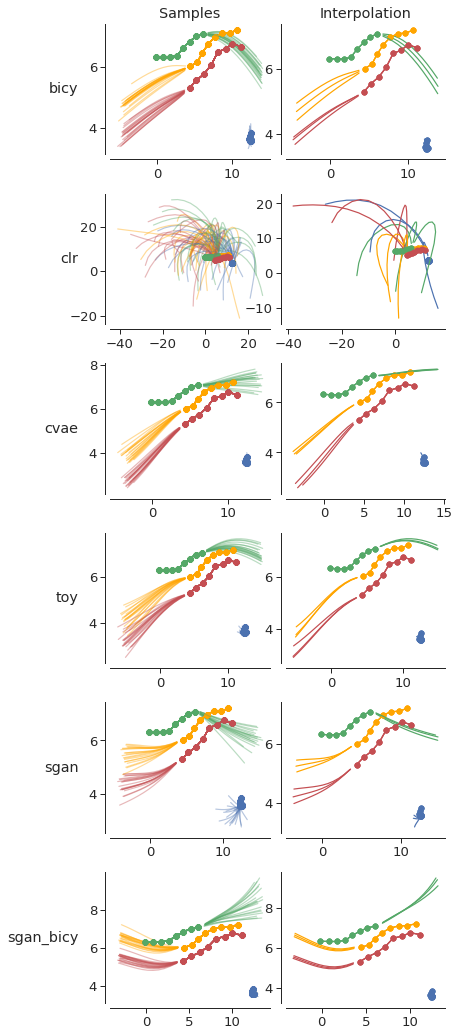

In [17]:
fig = vis.plot.init_figure(figsize=[6, 18])

for m, model_nickname in enumerate(model_nicknames):
    if model_nickname != 'sgan':
        fileprefix = '/fav/' + model_nickname + '*'
        root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
        filesearch = root_path + '/models' + fileprefix # can change here acc to saved epoch
        filelist = glob.glob(filesearch)
        filelist.sort()
        filename = filelist[0]
    
    if model_nickname == 'toy':
        generator = ToyGenerator(in_len=8, out_len=12)
        discriminator = ToyDiscriminator()
        solver = Solver(generator, discriminator)
    elif model_nickname == 'sgan':
        model_path = '../../sgan/sgan/models/sgan-p-models/'
        model = 'eth_12_model.pt'
        ###
        checkpoint = torch.load(model_path + model, map_location='cpu')
        generator = get_sgan_generator(checkpoint)
        solver = BaseSolver(generator, None)
        
    elif model_nickname == 'sgan_bicy':
        lr_gen = 1e-3
        lr_dis = 1e-3
        lr_enc = 1e-3
        loss_weights = {'disc': 1, 'traj': 1, 'kl': 0.01, 'z': 0.5}
        obs_len = 8,
        pred_len = 12
        embedding_dim = 16
        encoder_h_dim = 32
        decoder_h_dim = 32
        mlp_dim = 64
        num_layers = 1
        noise_dim = (8,)
        noise_type = 'gaussian'
        noise_mix_type = 'global'
        pooling_type = 'pool_net'
        model_path = '../../sgan/sgan/models/sgan-p-models/'
        model = 'eth_12_model.pt'
        ###
        checkpoint = torch.load(model_path + model, map_location='cpu')
        generator_sgan = get_sgan_generator(checkpoint)
        generator = BicycleGenerator(generator=generator_sgan,
                                     start_mode='cvae',
                                     embedding_dim=embedding_dim,
                                     h_dim=decoder_h_dim - 8,
                                     z_dim=8,
                                     in_len=obs_len,
                                     out_len=pred_len,
                                     noise_type=noise_type,
                                     noise_mix_type=noise_mix_type)

        discriminator = TrajectoryDiscriminator(obs_len=8,
                                                pred_len=12,
                                                embedding_dim=16,
                                                h_dim=64,
                                                mlp_dim=64,
                                                num_layers=1,
                                                dropout=0,
                                                batch_norm=0,
                                                d_type='local')
        solver = BicycleSolver(generator, discriminator,
                           loss_weights=loss_weights,
                           optims_args={'generator': {'lr': lr_gen},
                                        'discriminator': {'lr': lr_dis},
                                        'encoder': {'lr': lr_enc}})
#     elif model_nickname == 'bicy':
#         generator = BicycleGenerator(generator=ToyGenerator, start_mode='cvae')
#         solver=BicycleSolver(generator, None,
#                 loss_fns={'norm': nn.L1Loss, 'gan': nn.BCEWithLogitsLoss},
#                 optims_args={'generator': {'lr': 1}, 'discriminator': {'lr': 1}})
    
    else:# bicy or others
        generator = BicycleGenerator(generator=ToyGenerator, start_mode='clr')
        discriminator = ToyDiscriminator()
        solver = cLRSolver(generator, discriminator, 
                    optims_args={'generator': {'lr': 1}, 'discriminator': {'lr': 1}})
        
    if model_nickname != 'sgan': epochs = solver.load_checkpoint(filelist[0])
    
    interp = solver.interpolate(testloader, scene=scene, seed=seed, stepsize=stepsize)
    samples = solver.sample_distribution(testloader, scene=scene, seed=seed, z_dim=8, num_samples=num_samples)
    
    output = samples
    ax1 = vis.plot.init_subplot('', tot_tup=(6, 2), sp_tup=(m, 0))#plt.subplot(4, 2, m*2+1)
    ax1.text(-0.2, 0.5, model_nickname, transform=ax1.transAxes, va='center', ha='right')

    num_agents = output['xy_in'][0].shape[1]
    num_scenes = len(output['xy_in'])
    scenes_list = list(range(num_scenes))
    for s in scenes_list:
        for a in range(num_agents):
            ax1.plot( output['xy_in'][0][:, a, 0], output['xy_in'][0][:, a, 1],
                         'o-', c=color[a%len(color)], markersize=5, label=f'Input Agent {a}')
            if m==0: plt.title('Samples')
            ax1.plot( output['xy_pred'][s][:, a, 0], output['xy_pred'][s][:, a, 1],
                     '-',alpha=0.4, c=color[a%len(color)], markersize=5,  label=f'Prediction Agent {a}')
          
    output = interp
    ax1 = vis.plot.init_subplot('', tot_tup=(6, 2), sp_tup=(m, 1))#plt.subplot(4, 2, m*2+1)
    num_agents = output['xy_in'][0].shape[1]
    num_scenes = len(output['xy_in'])
    scenes_list = list(range(num_scenes))
    for s in scenes_list:
        for a in range(num_agents):
            ax1.plot( output['xy_in'][0][:, a, 0], output['xy_in'][0][:, a, 1],
                         'o-', c=color[a%len(color)], markersize=5, label=f'Input Agent {a}')
            ax1.plot( output['xy_pred'][s][:, a, 0], output['xy_pred'][s][:, a, 1],
                     '-', c=color[a%len(color)], markersize=5,  label=f'Prediction Agent {a}')
            if m==0: plt.title('Interpolation')

 
    
    #plt.savefig(figname)